In [1]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, isdir, join
from matplotlib import pyplot as plt

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.layers import Input, Dense, Conv1D, Flatten, Dropout, BatchNormalization
from keras.layers.merge import concatenate
from keras import Model

Using plaidml.keras.backend backend.


In [61]:
class DescriptorNet(keras.Model):
    def __init__(self):
        super(DescriptorNet, self).__init__()
        # Input 1 ground truth descriptors
        self.convA1 = Conv1D(1000, kernel_size=1, activation='relu')
        self.convA2 = Conv1D(500, kernel_size=1, activation='relu')
        self.convA3 = Conv1D(250, kernel_size=1, activation='relu')
        self.convA4 = Conv1D(125, kernel_size=1, activation='relu')
        self.convA5 = Conv1D(64, kernel_size=1, activation='relu')
        self.convA6 = Conv1D(32, kernel_size=1, activation='relu')
        self.convA7 = Conv1D(4, kernel_size=1, activation='relu')
        self.batchNormA1 = BatchNormalization()
        self.batchNormA2 = BatchNormalization()
        self.batchNormA3 = BatchNormalization()
        self.flatten1 = Flatten()
        
        # Input 2, NIR descriptors
        self.convB1 = Conv1D(1000, kernel_size=1, activation='relu')
        self.convB2 = Conv1D(500, kernel_size=1, activation='relu')
        self.convB3 = Conv1D(250, kernel_size=1, activation='relu')
        self.convB4 = Conv1D(125, kernel_size=1, activation='relu')
        self.convB5 = Conv1D(64, kernel_size=1, activation='relu')
        self.convB6 = Conv1D(32, kernel_size=1, activation='relu')
        self.convB7 = Conv1D(4, kernel_size=1, activation='relu')
        self.batchNormB1 = BatchNormalization()
        self.batchNormB2 = BatchNormalization()
        self.batchNormB3 = BatchNormalization()
        self.flatten2 = Flatten()
        
        # Merge
        self.dense1 = Dense(1024 , activation='relu')
        
        # Output 1, Rotation & skewness matrix (h11, h22)
        self.denseX1 = Dense(1024 , activation='relu')
        self.dropoutX1 = Dropout(0.33)
        self.output1 = Dense(2 , activation='tanh', name='rotation_output1')
        
        # Output 2, Rotation & skewness matrix (h12, h21)
        self.denseY1 = Dense(1024 , activation='relu')
        self.dropoutY1 = Dropout(0.33)
        self.output2 = Dense(2 , activation='tanh', name='rotation_output2')
        
        # Output 3, Translation matrix
        self.denseZ1 = Dense(1024 , activation='relu')
        self.dropoutZ1 = Dropout(0.33)
        self.output3 = Dense(2 , activation='linear', name='translation_output')
        
    def call(self, inputs):
        x = inputs[0]
        
        x = self.convA1(x)
        x = self.convA2(x)
        #x = self.batchNormA1(x)
        x = self.convA3(x)
        x = self.convA4(x)
        #x = self.batchNormA2(x)
        x = self.convA5(x)
        x = self.convA6(x)
        x = self.convA7(x)
        #x = self.batchNormA3(x)
        x = self.flatten1(x)
        
        y = inputs[1]
        y = self.convB1(y)
        y = self.convB2(y)
        #y = self.batchNormB1(y)
        y = self.convB3(y)
        y = self.convB4(y)
        #y = self.batchNormB2(y)
        y = self.convB5(y)
        y = self.convB6(y)
        y = self.convB7(y)
        #y = self.batchNormB3(y)
        y = self.flatten2(y)
        
        neck = concatenate([x, y])
        neck = self.dense1(neck)
        
        z1 = self.denseX1(neck)
        z1 = self.dropoutX1(z1)
        z1 = self.output1(z1)
        z2 = self.denseY1(neck)
        z2 = self.dropoutY1(z2)
        z2 = self.output2(z2)
        z3 = self.denseZ1(neck)
        z3 = self.dropoutZ1(z3)
        z3 = self.output3(z3)
        
        return [z1, z2, z3]
    
    def model(self):
        x = Input(shape=(128, 2000))
        y = Input(shape=(128, 2000))
        return Model(inputs=[x, y], outputs=self.call([x, y]))
        

In [62]:
model = DescriptorNet()
model.model().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 128, 2000)    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 128, 2000)    0                                            
__________________________________________________________________________________________________
conv1d_85 (Conv1D)              (None, 128, 1000)    2001000     input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_92 (Conv1D)              (None, 128, 1000)    2001000     input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_86 

In [63]:
H = np.load('HomoMat.npy')
GroundDes = np.load('GroundDes.npy')
NirDes = np.load('NirDes.npy')


train_x = [GroundDes, NirDes]
train_y = [np.array([H[:, 0, 0], H[:, 1, 1]]).transpose(), 
           np.array([H[:, 1, 0], H[:, 0, 1]]).transpose(),
           H[:, :, 2]
          ]

# train_y = np.delete(train_y, -1, axis=1)
print('X.shape')
print(train_x[0].shape)
print(train_x[1].shape)
print('Y.shape')
print(train_y[0].shape)
print(train_y[1].shape)
print(train_y[2].shape)

X.shape
(137, 128, 2000)
(137, 128, 2000)
Y.shape
(137, 2)
(137, 2)
(137, 2)


### Weights Adjustment

Loss weights should be adjusted among each period, which shown as below by [output_1, output_2, output_3]
- Period 1: [5, 10000, 1]
- Period 2: [1, 1000, 1]

In [74]:
opt = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='mse', optimizer=opt, loss_weights=[1, 1000, 10])
history = model.fit(train_x, train_y, batch_size=32, epochs=500, validation_split=0.0)


Epoch 1/500
137/137 [==============================] - 23s 169ms/step - loss: 27.1408 - output_1_loss: 1.7126e-05 - output_2_loss: 5.9004e-08 - output_3_loss: 2.7141
Epoch 2/500
137/137 [==============================] - 1s 4ms/step - loss: 19.7623 - output_1_loss: 1.8504e-05 - output_2_loss: 3.5867e-08 - output_3_loss: 1.9762
Epoch 3/500
137/137 [==============================] - 1s 4ms/step - loss: 27.7405 - output_1_loss: 1.8311e-05 - output_2_loss: 3.2877e-08 - output_3_loss: 2.7740
Epoch 4/500
137/137 [==============================] - 1s 4ms/step - loss: 20.1946 - output_1_loss: 1.7851e-05 - output_2_loss: 2.8426e-08 - output_3_loss: 2.0195
Epoch 5/500
137/137 [==============================] - 1s 4ms/step - loss: 19.1369 - output_1_loss: 2.4491e-05 - output_2_loss: 5.9734e-08 - output_3_loss: 1.9137
Epoch 6/500
137/137 [==============================] - 1s 4ms/step - loss: 26.9570 - output_1_loss: 1.6156e-05 - output_2_loss: 3.4520e-08 - output_3_loss: 2.6957
Epoch 7/500
137/137

Epoch 51/500
137/137 [==============================] - 1s 4ms/step - loss: 19.7816 - output_1_loss: 1.6131e-05 - output_2_loss: 2.8532e-08 - output_3_loss: 1.9782
Epoch 52/500
137/137 [==============================] - 1s 4ms/step - loss: 19.3510 - output_1_loss: 1.5047e-05 - output_2_loss: 2.3998e-08 - output_3_loss: 1.9351
Epoch 53/500
137/137 [==============================] - 1s 4ms/step - loss: 19.5882 - output_1_loss: 1.5665e-05 - output_2_loss: 3.4779e-08 - output_3_loss: 1.9588
Epoch 54/500
137/137 [==============================] - 1s 4ms/step - loss: 20.3560 - output_1_loss: 1.5903e-05 - output_2_loss: 2.9479e-08 - output_3_loss: 2.0356
Epoch 55/500
137/137 [==============================] - 1s 4ms/step - loss: 24.8254 - output_1_loss: 1.5092e-05 - output_2_loss: 5.3326e-08 - output_3_loss: 2.4825
Epoch 56/500
137/137 [==============================] - 1s 4ms/step - loss: 23.9385 - output_1_loss: 1.7272e-05 - output_2_loss: 4.1163e-08 - output_3_loss: 2.3938
Epoch 57/500
137

137/137 [==============================] - 1s 4ms/step - loss: 19.0610 - output_1_loss: 1.3475e-05 - output_2_loss: 3.0707e-08 - output_3_loss: 1.9061
Epoch 101/500
137/137 [==============================] - 1s 4ms/step - loss: 18.9777 - output_1_loss: 1.2885e-05 - output_2_loss: 3.6244e-08 - output_3_loss: 1.8978
Epoch 102/500
137/137 [==============================] - 1s 4ms/step - loss: 20.8949 - output_1_loss: 1.1628e-05 - output_2_loss: 2.7895e-08 - output_3_loss: 2.0895
Epoch 103/500
137/137 [==============================] - 1s 4ms/step - loss: 23.4178 - output_1_loss: 1.2756e-05 - output_2_loss: 2.4220e-08 - output_3_loss: 2.3418
Epoch 104/500
137/137 [==============================] - 1s 4ms/step - loss: 19.4406 - output_1_loss: 1.4017e-05 - output_2_loss: 5.2514e-08 - output_3_loss: 1.9441
Epoch 105/500
137/137 [==============================] - 1s 4ms/step - loss: 22.0582 - output_1_loss: 1.2021e-05 - output_2_loss: 2.4236e-08 - output_3_loss: 2.2058
Epoch 106/500
137/137 [=

137/137 [==============================] - 1s 4ms/step - loss: 22.5496 - output_1_loss: 1.3649e-05 - output_2_loss: 5.7521e-08 - output_3_loss: 2.2550
Epoch 150/500
137/137 [==============================] - 1s 4ms/step - loss: 21.6053 - output_1_loss: 1.1938e-05 - output_2_loss: 2.9561e-08 - output_3_loss: 2.1605
Epoch 151/500
137/137 [==============================] - 1s 4ms/step - loss: 20.3765 - output_1_loss: 1.1937e-05 - output_2_loss: 5.4833e-08 - output_3_loss: 2.0376
Epoch 152/500
137/137 [==============================] - 1s 4ms/step - loss: 23.4750 - output_1_loss: 1.3203e-05 - output_2_loss: 2.4876e-08 - output_3_loss: 2.3475
Epoch 153/500
137/137 [==============================] - 1s 4ms/step - loss: 21.0645 - output_1_loss: 9.6625e-06 - output_2_loss: 3.2257e-08 - output_3_loss: 2.1064
Epoch 154/500
137/137 [==============================] - 1s 4ms/step - loss: 17.4638 - output_1_loss: 1.1917e-05 - output_2_loss: 3.1095e-08 - output_3_loss: 1.7464
Epoch 155/500
137/137 [=

137/137 [==============================] - 1s 4ms/step - loss: 20.4263 - output_1_loss: 1.0989e-05 - output_2_loss: 2.4152e-08 - output_3_loss: 2.0426
Epoch 199/500
137/137 [==============================] - 1s 4ms/step - loss: 21.8893 - output_1_loss: 9.7025e-06 - output_2_loss: 2.3871e-08 - output_3_loss: 2.1889
Epoch 200/500
137/137 [==============================] - 1s 4ms/step - loss: 31.2040 - output_1_loss: 9.2152e-06 - output_2_loss: 2.4021e-08 - output_3_loss: 3.1204
Epoch 201/500
137/137 [==============================] - 1s 4ms/step - loss: 23.1654 - output_1_loss: 1.0703e-05 - output_2_loss: 2.5421e-08 - output_3_loss: 2.3165
Epoch 202/500
137/137 [==============================] - 1s 4ms/step - loss: 20.4706 - output_1_loss: 1.0720e-05 - output_2_loss: 4.9356e-08 - output_3_loss: 2.0471
Epoch 203/500
137/137 [==============================] - 1s 4ms/step - loss: 22.5974 - output_1_loss: 1.1076e-05 - output_2_loss: 2.4043e-08 - output_3_loss: 2.2597
Epoch 204/500
137/137 [=

137/137 [==============================] - 1s 4ms/step - loss: 19.9453 - output_1_loss: 9.8541e-06 - output_2_loss: 5.7659e-08 - output_3_loss: 1.9945
Epoch 248/500
137/137 [==============================] - 1s 4ms/step - loss: 28.3350 - output_1_loss: 1.1723e-05 - output_2_loss: 2.9097e-08 - output_3_loss: 2.8335
Epoch 249/500
137/137 [==============================] - 1s 4ms/step - loss: 25.3982 - output_1_loss: 9.6631e-06 - output_2_loss: 4.0901e-08 - output_3_loss: 2.5398
Epoch 250/500
137/137 [==============================] - 1s 4ms/step - loss: 20.9989 - output_1_loss: 1.0517e-05 - output_2_loss: 3.6399e-08 - output_3_loss: 2.0999
Epoch 251/500
137/137 [==============================] - 1s 4ms/step - loss: 25.8469 - output_1_loss: 1.0185e-05 - output_2_loss: 3.4743e-08 - output_3_loss: 2.5847
Epoch 252/500
137/137 [==============================] - 1s 4ms/step - loss: 23.3512 - output_1_loss: 9.7836e-06 - output_2_loss: 2.3280e-08 - output_3_loss: 2.3351
Epoch 253/500
137/137 [=

137/137 [==============================] - 1s 5ms/step - loss: 18.9233 - output_1_loss: 8.0213e-06 - output_2_loss: 2.4793e-08 - output_3_loss: 1.8923
Epoch 297/500
137/137 [==============================] - 1s 4ms/step - loss: 23.6367 - output_1_loss: 7.9431e-06 - output_2_loss: 2.3827e-08 - output_3_loss: 2.3637
Epoch 298/500
137/137 [==============================] - 1s 4ms/step - loss: 18.8972 - output_1_loss: 8.1645e-06 - output_2_loss: 2.4615e-08 - output_3_loss: 1.8897
Epoch 299/500
137/137 [==============================] - 1s 4ms/step - loss: 22.2459 - output_1_loss: 8.4568e-06 - output_2_loss: 2.3986e-08 - output_3_loss: 2.2246
Epoch 300/500
137/137 [==============================] - 1s 4ms/step - loss: 22.2331 - output_1_loss: 8.9213e-06 - output_2_loss: 2.3830e-08 - output_3_loss: 2.2233
Epoch 301/500
137/137 [==============================] - 1s 4ms/step - loss: 22.5595 - output_1_loss: 8.2204e-06 - output_2_loss: 8.9613e-08 - output_3_loss: 2.2559
Epoch 302/500
137/137 [=

137/137 [==============================] - 1s 4ms/step - loss: 20.3297 - output_1_loss: 7.3806e-06 - output_2_loss: 2.6446e-08 - output_3_loss: 2.0330
Epoch 346/500
137/137 [==============================] - 1s 4ms/step - loss: 28.1133 - output_1_loss: 6.4055e-06 - output_2_loss: 2.6547e-08 - output_3_loss: 2.8113
Epoch 347/500
137/137 [==============================] - 1s 4ms/step - loss: 18.9641 - output_1_loss: 7.3004e-06 - output_2_loss: 2.3143e-08 - output_3_loss: 1.8964
Epoch 348/500
137/137 [==============================] - 1s 4ms/step - loss: 23.9316 - output_1_loss: 8.8447e-06 - output_2_loss: 2.2439e-08 - output_3_loss: 2.3932
Epoch 349/500
137/137 [==============================] - 1s 4ms/step - loss: 23.9119 - output_1_loss: 7.0580e-06 - output_2_loss: 2.7032e-08 - output_3_loss: 2.3912
Epoch 350/500
137/137 [==============================] - 1s 4ms/step - loss: 27.9241 - output_1_loss: 7.8319e-06 - output_2_loss: 2.9110e-08 - output_3_loss: 2.7924
Epoch 351/500
137/137 [=

137/137 [==============================] - 1s 4ms/step - loss: 26.8700 - output_1_loss: 6.3251e-06 - output_2_loss: 2.5877e-08 - output_3_loss: 2.6870
Epoch 395/500
137/137 [==============================] - 1s 4ms/step - loss: 21.2033 - output_1_loss: 7.7570e-06 - output_2_loss: 5.1814e-08 - output_3_loss: 2.1203
Epoch 396/500
137/137 [==============================] - 1s 4ms/step - loss: 22.0473 - output_1_loss: 7.0778e-06 - output_2_loss: 3.2616e-08 - output_3_loss: 2.2047
Epoch 397/500
137/137 [==============================] - 1s 4ms/step - loss: 19.5172 - output_1_loss: 6.2813e-06 - output_2_loss: 3.1862e-08 - output_3_loss: 1.9517
Epoch 398/500
137/137 [==============================] - 1s 4ms/step - loss: 23.5639 - output_1_loss: 6.4345e-06 - output_2_loss: 2.9020e-08 - output_3_loss: 2.3564
Epoch 399/500
137/137 [==============================] - 1s 4ms/step - loss: 18.9380 - output_1_loss: 7.6747e-06 - output_2_loss: 3.8958e-08 - output_3_loss: 1.8938
Epoch 400/500
137/137 [=

137/137 [==============================] - 1s 4ms/step - loss: 25.1043 - output_1_loss: 4.9665e-06 - output_2_loss: 2.5893e-08 - output_3_loss: 2.5104
Epoch 444/500
137/137 [==============================] - 1s 4ms/step - loss: 37.3511 - output_1_loss: 5.6912e-06 - output_2_loss: 2.5999e-08 - output_3_loss: 3.7351
Epoch 445/500
137/137 [==============================] - 1s 4ms/step - loss: 26.7472 - output_1_loss: 6.9262e-06 - output_2_loss: 2.8923e-08 - output_3_loss: 2.6747
Epoch 446/500
137/137 [==============================] - 1s 4ms/step - loss: 17.1873 - output_1_loss: 5.9690e-06 - output_2_loss: 2.5019e-08 - output_3_loss: 1.7187
Epoch 447/500
137/137 [==============================] - 1s 4ms/step - loss: 20.4961 - output_1_loss: 5.5221e-06 - output_2_loss: 2.6822e-08 - output_3_loss: 2.0496
Epoch 448/500
137/137 [==============================] - 1s 4ms/step - loss: 19.6581 - output_1_loss: 5.0228e-06 - output_2_loss: 4.0633e-08 - output_3_loss: 1.9658
Epoch 449/500
137/137 [=

137/137 [==============================] - 1s 4ms/step - loss: 22.1696 - output_1_loss: 5.3240e-06 - output_2_loss: 2.8328e-08 - output_3_loss: 2.2170
Epoch 493/500
137/137 [==============================] - 1s 4ms/step - loss: 26.0481 - output_1_loss: 5.2193e-06 - output_2_loss: 2.7780e-08 - output_3_loss: 2.6048
Epoch 494/500
137/137 [==============================] - 1s 4ms/step - loss: 18.4390 - output_1_loss: 4.9638e-06 - output_2_loss: 5.6803e-08 - output_3_loss: 1.8439
Epoch 495/500
137/137 [==============================] - 1s 4ms/step - loss: 25.0047 - output_1_loss: 6.2512e-06 - output_2_loss: 5.7313e-08 - output_3_loss: 2.5005
Epoch 496/500
137/137 [==============================] - 1s 4ms/step - loss: 26.2421 - output_1_loss: 6.3670e-06 - output_2_loss: 3.6319e-08 - output_3_loss: 2.6242
Epoch 497/500
137/137 [==============================] - 1s 4ms/step - loss: 22.4669 - output_1_loss: 4.7866e-06 - output_2_loss: 3.3586e-08 - output_3_loss: 2.2467
Epoch 498/500
137/137 [=

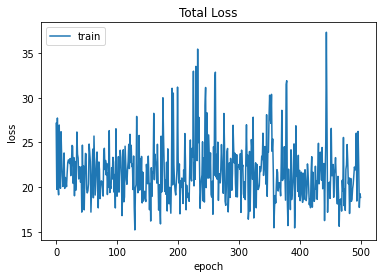

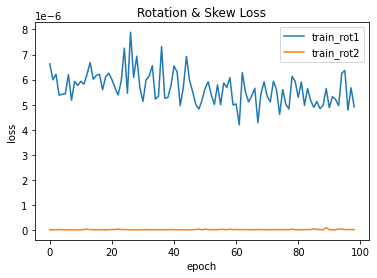

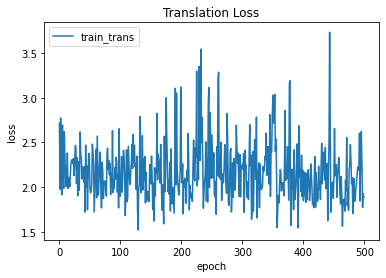

In [75]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'][-100:-1])
plt.title('Total Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.figure()
plt.plot(history.history['output_1_loss'][-100:-1])
plt.plot(history.history['output_2_loss'][-100:-1])
#plt.plot(history.history['val_output_1_loss'][-100:-1])
#plt.plot(history.history['val_output_2_loss'][-100:-1])
plt.title('Rotation & Skew Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_rot1', 'train_rot2', 'test_rot1', 'test_rot2'])
plt.show()

plt.figure()
plt.plot(history.history['output_3_loss'])
#plt.plot(history.history['val_output_3_loss'][-100:-1])
plt.title('Translation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_trans', 'test_trans'])
plt.show()

In [114]:
def SIFT(img):
    siftDetector= cv2.xfeatures2d.SIFT_create(2000)
    kp, des = siftDetector.detectAndCompute(img, None)
    return kp, des

name = '0300'

img1 = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
_, des1 = SIFT(img1)
_, des2 = SIFT(img2)
des1 = np.expand_dims(des1.transpose(), axis=0) / 512
des2 = np.expand_dims(des2.transpose(), axis=0) / 512

p = model.predict([des1, des2])
p = np.array(
    [[p[0].squeeze()[0], p[1].squeeze()[1], p[2].squeeze()[0]],
     [p[1].squeeze()[0], p[0].squeeze()[1], p[2].squeeze()[1]]])
h = H[1]

In [117]:
print(p)
print()
print(h)

head = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img = np.zeros((head.shape[0], head.shape[1], 3), dtype='uint8')
img[:, :, 0] = head
img[:, :, 1] = 0 #cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_3toIMG_{name}_2_registered.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img[:, :, 2] = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)

height, width, channels = img.shape
img[:,:,2] = cv2.warpAffine(img[:,:,2], p, (width, height))
cv2.imshow('Reg', img)
cv2.imwrite('{}_Reg.tif'.format(name), img)

img[:, :, 2] = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img[:,:,2] = cv2.warpAffine(img[:,:,2], h, (width, height))
cv2.imshow('Reg_H1', img)
cv2.imwrite('{}_Reg_H1.tif'.format(name), img)

cv2.waitKey(0)
cv2.destroyAllWindows()

[[ 9.9463344e-01  2.8364707e-04  3.3774799e+01]
 [-2.8543032e-04  9.9393541e-01 -3.4180309e+01]]

[[ 9.93996270e-01  2.22479887e-04  3.32327106e+01]
 [-2.22479887e-04  9.93996270e-01 -3.45610212e+01]]


In [118]:
model.save_weights('./weights/DescriptorNet_weights_202019Aug.h5')